In [1]:
import os
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
print(BASE_DIR)

import math

import numpy as np
import pandas as pd

import bokeh.plotting as bp
from bokeh.models import tools as bmt, ColumnDataSource

from bokeh.io import output_notebook, export_png
output_notebook()

from IPython.display import Image

/Users/biplovbhandari/UAH/Fall_2021/ESS_690_Hydrology/ess-690-hydrology


Loading BokehJS ...

In [2]:
BASE_DIR = f'{BASE_DIR}/HW#3'
BASE_DIR

'/Users/biplovbhandari/UAH/Fall_2021/ESS_690_Hydrology/ess-690-hydrology/HW#3'

In [3]:
def initialize_fig(title: str = 'your_title',
                   x_axis_label: str = 'x_axis_label',
                   x_axis_type: str = 'auto',
                   y_axis_label: str = 'y_axis_label',
                   y_axis_type: str = 'auto',
                   tools: str = 'pan,wheel_zoom,box_zoom,reset',
                   tooltips: list = [],
                   formatters: dict = {},
                   plot_height: int = 300,
                   fig_sizing_mode: str = 'scale_width',
                   ) -> bp.figure:
    # bokeh style
    TOOLS = tools
    hover_tool = bmt.HoverTool(tooltips=tooltips, formatters=formatters)

    fig = bp.figure(title=title,
                    x_axis_label=x_axis_label,
                    x_axis_type=x_axis_type,
                    y_axis_label=y_axis_label,
                    y_axis_type=y_axis_type,
                    plot_height=plot_height,
                    tools=TOOLS,
                   )
    fig.add_tools(hover_tool)
    fig.sizing_mode = fig_sizing_mode

    return fig

### Question 1

#### 1.	Chapter 6, Exercise 1a estimate evaporation with the water balance equation.

In [4]:
A_basin = 52.1 # area of basin in km2
A_basin = A_basin * 1e6 # area of basin in m2
A_lake = 4.2 # area of lake in km2
A_lake = A_lake * 1e6 # area of lake in m2

P = 1083 # precipitation in mm
P = P / 1000. # precipitation in m
P = P * A_lake # precipitation in m3 for lake

Q_in = 2.33e7 # discharge inflow in m3
GW_in = 2.2e5 # ground-water inflow in m3
GW_out = 0.6e5 # ground-water outflow in m3
Q_out = 2.7e7 # discharge outflow in m3

D = 108 # depth of water in mm
D = D / 1000. # depth of water in m
D = D * A_lake # depth of water in m3

# using the water-balance equation
# inflow - outflow = change in storage
E = GW_in + P + Q_in - GW_out - Q_out - D

In [5]:
E # volumertic in m3

555000.0

In [6]:
E = E / A_lake # depth in m

In [7]:
E

0.13214285714285715

### Question 2

#### 1.	Chapter 6, Exercise 3a.

In [8]:
Ta = 22.3 # temperature at the 2m in degree celsius
RH = 0.68 # relative humidity
u = 2.16 # wind-speed at 2m in m/s
Ts = 23.7 # surface temperature in degree celsius
P = 97.3 # pressure in kPa
Kin = 16.2 # net shortwave radiation input in MJ/m2.d
α = 0.057 # albedo
Lin = 30.6 # net longwave radiation input in MJ/m2.d

#### Mass Transfer

In [9]:
es = 0.611 * math.exp((17.3 * Ts) / (Ts + 237.3))
es # kPa

2.9395638512166538

In [10]:
e_astrik_2m = 0.611 * math.exp((17.3 * Ta) / (Ta + 237.3))
e_astrik_2m # kPa

2.7004965700799994

In [11]:
e_2m = RH * e_astrik_2m
e_2m #kPa

1.8363376676543997

In [12]:
# constant KE
# Area of lake
A = 9.4 # km2
KE = 1.26 * math.pow(A, -0.05)
KE

1.1264557920614817

In [13]:
# evaporation rate
E0 = KE * u * (es - e_2m) # mm/day
E0 # mm/day

2.684308732763583

#### Energy Balance

In [14]:
# Net shortwave radiation
K = Kin * (1 - α) # MJ/m2.d
K

15.276599999999998

In [15]:
# Net longwave radiation
# L = Lin - Lout
εs = 0.95 # integrated effective emissivity for water
σ = 4.9e-9 # MJ/m2.K4.d
Lout = εs * σ * math.pow((273.15 + Ts), 4) + (1 - εs) * Lin # MJ/m2.d

In [16]:
Lout

37.676637051244946

In [17]:
L = Lin - Lout # MJ/m2.d

In [18]:
L

-7.076637051244944

In [19]:
KH = (1.95e-4) / math.pow((math.log(2 / 0.0012)), 2) # MJ/m3.K

In [20]:
KH # MJ/m3.K

3.54317772453322e-06

In [21]:
# upward rate of sensible-heat exchange
H = KH * u * (Ts - Ta) # MJ/m2.sec

In [22]:
H = H * 86400. # MJ/m2.day
H

0.9257387995286017

In [23]:
λv = 2.5 - 2.36e-3 * Ts # MJ/kg
λv

2.444068

In [24]:
# density of water
ρw = 996 # kg/m3
# evaporation
E0 = (K + L - H) / (ρw * λv) # m/day

In [25]:
E0 = E0 * 1000. # mm/day
E0

2.9882302377960723

#### Combination

In [26]:
Δ_T = (2508.3 * math.exp((17.3 * Ta) / (Ta + 237.3))) / (math.pow((Ta + 237.3), 2)) # kPa/°C
Δ_T

0.16450250727809462

In [27]:
cp = 1.0e-3 # MJ/kg.C
γ = (cp * P) / (0.622 * λv) # kPa/°C
γ

0.06400430273102162

In [28]:
# multiplying KE by 1e-3 m/mm to give consistent units (s/kPa.day)
numerator = Δ_T * (K - L) + (γ * (KE * 1e-3) * ρw * λv * u * e_astrik_2m * (1. - RH))
denominator = ρw * λv * (Δ_T + γ)

E0 = numerator / denominator # m/day

In [29]:
E0 = E0 * 1000. # mm/day
E0

7.199545149771036

### Question 3

#### Chapter 6, Exercise 9.

In [30]:
Ta = 20.7 # temperature at the 2m in degree celsius
RH = 0.49 # relativity humidity
K_L = 13.9 # net shortwave radiation (K) + net longwave radiation (L) in MJ/m2.d
zm = 3.66 # elevation in m
zveg = 0.5 # vegetation elevation in m
u = 2.48 # wind speed at zm in m/s
P = 101.3 # pressure in kPa
D = 14.8 # duration in hour
C_astrik_leaf = 0.0050 # conductance of leaf in m/s
LAI = 4.5 # Leaf Area Index
ks = 0.5 # constant

In [31]:
ρa = 1.29 # air density in kg/m3
ρw = 996 # # density of water in kg/m3
cp = 1.0e-3 # Air specific heat in MJ/kg.C
zd = 0.7 * zveg
z0 = 0.1 * zveg

#### The Penman-Monteith Model

In [32]:
# Atmospheric Conductance
Cat = u / ( 6.25 * math.pow(math.log((zm - zd) / z0), 2) )
Cat # m/s

0.02257294035244845

In [33]:
Cat = Cat * 86400. # m/day
Cat

1950.302046451546

In [34]:
e_astrik_Ta = 0.611 * math.exp((17.3 * Ta) / (Ta + 237.3))
e_astrik_Ta # kPa

2.4482290733901433

In [35]:
λv = 2.5 - 2.36e-3 * Ta # MJ/kg
λv

2.451148

In [36]:
γ = (cp * P) / (0.622 * λv) # kPa/°C
γ

0.06644304478326285

In [37]:
# canopy conductance
Ccan = ks * LAI * C_astrik_leaf # m/s
Ccan

0.01125

In [38]:
Ccan = Ccan * 86400. # m/day
Ccan

972.0

In [39]:
Δ_T = (2508.3 * math.exp((17.3 * Ta) / (Ta + 237.3))) / (math.pow((Ta + 237.3), 2)) # kPa/°C
Δ_T

0.1509909463057027

In [40]:
ET_num_1 = ρa * cp * Cat * e_astrik_Ta
ET_num_2 = ET_num_1 * (1. - RH)
ET_num = (Δ_T * K_L) + ET_num_2

ET_denom_1 = γ * ( 1. + (Cat / Ccan))
ET_denom_2 = Δ_T + ET_denom_1
ET_denom = ρw * λv * ET_denom_2

ET = ET_num / ET_denom # m/day
ET

0.006119450700143533

In [41]:
ET = ET * 1000 # mm/day
ET

6.119450700143533

#### Hamon Method

In [42]:
PET = 29.8 * D * e_astrik_Ta / (Ta + 273.2) # mm/day
PET

3.6739263372847533

#### Priestley and Taylor Method

In [43]:
αpt = 1.26

In [44]:
PET = (αpt * Δ_T * K_L) / (ρw * λv * (Δ_T + γ))
PET # m/day

0.004981727198002928

In [45]:
PET = PET * 1000 # mm/day
PET

4.981727198002928

### Question 4

#### FAO PT Method

In [46]:
# constants
cp = 1.013e-3 # Air specific heat in MJ/kg.C
latitude = 34.723
longitude = 86.642
z = 212.
σ = 4.903e-9 # MJ/m2.K4.d
αpt = 1.26
ρw = 996 # # density of water in kg/m3
λv = 2.45 # MJ/kg

In [47]:
column_names = ['const', 'year', 'julian_day', 'HM', 'S', 'pressure', 'temp_2m', 'RH_2m', '_', 'temp_10m', 'u_10m', 'ud_10m', 'Rin', 'rain', 'temp_0.5m', 'temp_1m']

In [48]:
df_10 = pd.read_csv(f'{BASE_DIR}/brm_20120610_sfc.csv', names=column_names)
df_10['datetime'] = '2012-06-10'

df_11 = pd.read_csv(f'{BASE_DIR}/brm_20120611_sfc.csv', names=column_names)
df_11['datetime'] = '2012-06-11'

df_12 = pd.read_csv(f'{BASE_DIR}/brm_20120612_sfc.csv', names=column_names)
df_12['datetime'] = '2012-06-12'

df_13 = pd.read_csv(f'{BASE_DIR}/brm_20120613_sfc.csv', names=column_names)
df_13['datetime'] = '2012-06-13'

df_14 = pd.read_csv(f'{BASE_DIR}/brm_20120614_sfc.csv', names=column_names)
df_14['datetime'] = '2012-06-14'

df_15 = pd.read_csv(f'{BASE_DIR}/brm_20120615_sfc.csv', names=column_names)
df_15['datetime'] = '2012-06-15'

df_16 = pd.read_csv(f'{BASE_DIR}/brm_20120616_sfc.csv', names=column_names)
df_16['datetime'] = '2012-06-16'

In [49]:
df_days = [df_10, df_11, df_12, df_13, df_14, df_15, df_16]

In [50]:
df = pd.DataFrame(columns=[
    'datetime', 'temp_mean_2m', 'Rin_avg', 'u_avg_2m', 'Δ_T', 'pressure_avg',
    'γ', 'DT', 'PT', 'TT', 'es', 'ea', 'dr', 'δ',  'φ_rad', 'ωs',
    'Ra', 'Rso', 'Rns', 'Rnl', 'Rn', 'Rng', 'ETrad', 'ETwind', 'ET0_PM', 'PET_PT'
])

for df_day in df_days:
    # convert from fahrenheit to celsius
    df_day['temp_2m'] = (df_day['temp_2m'] - 32.) * (5. / 9.)
    # calculate mean temperature
    temp_mean_2m = (df_day['temp_2m'].max() + df_day['temp_2m'].min()) / 2

    # average daily radiation in MJ.m-2.day-1
    Rin_avg = df_day['Rin'].mean() * 0.0864

    # average wind speed at 2m
    u_avg_2m = (df_day['u_10m'] * 4.87 / math.log(672.58)).mean()
    
    # slope of saturation vapor pressure curve
    Δ_T = 4098 * (0.6108 * math.exp((17.27 * temp_mean_2m) / (temp_mean_2m + 237.3))) / (temp_mean_2m + 237.3)**2
    
    # average pressure
    pressure_avg = df_day['pressure'].mean()
    
    # Psychrometric constant
    γ = 0.000665 * pressure_avg

    # Delta Term (DT) (auxiliary calculation for Radiation Term)
    DT = Δ_T / (Δ_T + γ * (1 + 0.34 * u_avg_2m))

    # Psi Term (PT) (auxiliary calculation for Wind Term)
    PT = γ / (Δ_T + γ * (1 + 0.34 * u_avg_2m))
    
    # Temperature Term (TT) (auxiliary calculation for Wind Term)
    TT = (900. * u_avg_2m) / (temp_mean_2m + 273.)

    # Mean saturation vapor pressure derived from air temperature(es)
    e_tmax = 0.6108 * math.exp( (17.27 * df_day['temp_2m'].max()) / (df_day['temp_2m'].max() + 237.7) )
    e_tmin = 0.6108 * math.exp( (17.27 * df_day['temp_2m'].min()) / (df_day['temp_2m'].min() + 237.7) )
    es = (e_tmax + e_tmin) / 2.
    
    # Actual vapor pressure (ea) derived from relative humidity
    ea = (df_day['RH_2m'].mean() / 100.) * ((e_tmin + e_tmax) / 2.)
    
    # The inverse relative distance Earth-Sun (dr) and solar declination (δ)
    # the julian_day value is same, so mean would give the same value
    dr = 1 + 0.033 * math.cos(2 * math.pi * df_day['julian_day'].mean() / 365. )
    δ = 0.409 * math.sin( (2 * math.pi * df_day['julian_day'].mean() / 365.) - 1.39 )
    
    # Conversion of latitude (φ) in degrees to radians
    φ_rad = math.pi * latitude / 180.
    
    # Sunset hour angle
    ωs = math.acos(-1. * math.tan(φ_rad) * math.tan(δ))
    
    # Extraterrestrial radiation (Ra)
    term_1 = (ωs * math.sin(φ_rad) * math.sin(δ)) + (math.cos(φ_rad) * math.cos(δ) * math.sin(ωs))
    Ra = 24. * 60. / math.pi * 0.0820 * dr * term_1
    
    # Clear sky solar radiation (Rso)
    Rso = (0.75 + 2 * 10**-5 * z) * Ra
    
    # Net solar or net shortwave radiation (Rns)
    Rns = (1. - 0.23) * Rin_avg
    
    # Net outgoing long wave solar radiation (Rnl)
    term_1 = ((df_day['temp_2m'].max() + 273.16)**4 + (df_day['temp_2m'].min() + 273.16)**4) / 2.
    term_2 = (0.34 - 0.14 * math.sqrt(ea))
    term_3 = 1.35 * (Rin_avg / Rso ) - 0.35
    Rnl = σ * term_1 * term_2 * term_3
    
    # Net radiation (Rn)
    Rn = Rns - Rnl
    # Net raduation in equivalent of evaporation (mm)
    Rng = 0.408 * Rn
    
    # FS1. Radiation term (ETrad)
    ETrad = DT * Rng
    
    # FS2. Wind term (ETwind)
    ETwind = PT * TT * (es - ea)
    
    # Final Reference Evapotranspiration Value (ETo)
    ET0_PM = ETwind + ETrad

    # Priestly Taylor
    PET_PT = (αpt * Δ_T * (Rns + Rnl)) / (ρw * λv * (Δ_T + γ)) # m/day
    PET_PT = PET_PT * 1000
    
    df_row = {
        'datetime'     : df_day.datetime.iloc[0],
        'temp_mean_2m' : temp_mean_2m,
        'Rin_avg'      : Rin_avg,
        'u_avg_2m'     : u_avg_2m,
        'Δ_T'          : Δ_T,
        'pressure_avg' : pressure_avg,
        'γ'            : γ,
        'DT'           : DT,
        'PT'           : PT,
        'TT'           : TT,
        'es'           : es,
        'ea'           : ea,
        'dr'           : dr,
        'δ'            : δ,
        'φ_rad'        : φ_rad,
        'ωs'           : ωs,
        'Ra'           : Ra,
        'Rso'          : Rso,
        'Rns'          : Rns,
        'Rnl'          : Rnl,
        'Rn'           : Rn,
        'Rng'          : Rng,
        'ETrad'        : ETrad,
        'ETwind'       : ETwind,
        'ET0_PM'       : ET0_PM,
        'PET_PT'       : PET_PT,
        
    }
    df = df.append(df_row, ignore_index=True)

df.index = pd.to_datetime(df['datetime'])
df = df.drop(['datetime'], axis=1)

In [51]:
df

,temp_mean_2m,Rin_avg,u_avg_2m,Δ_T,pressure_avg,γ,DT,PT,TT,es,...,Ra,Rso,Rns,Rnl,Rn,Rng,ETrad,ETwind,ET0_PM,PET_PT
datetime,,,,,,,,,,,,,,,,,,,,,
2012-06-10,23.361111,6.002230,1.650785,0.173185,991.112528,0.659090,0.144057,0.548236,5.013162,2.926863,...,41.528136,31.322181,4.621717,-0.436628,5.058345,2.063805,0.297306,1.625499,1.922804,0.449670
2012-06-11,25.495000,15.381470,1.714691,0.193586,991.194950,0.659145,0.156495,0.532854,5.170008,3.352729,...,41.547958,31.337132,11.843732,1.234572,10.609160,4.328537,0.677395,1.214647,1.892042,1.533057
2012-06-12,24.288056,20.554892,1.837365,0.181812,991.443340,0.659310,0.145102,0.526187,5.562378,3.119542,...,41.565212,31.350145,15.827267,2.522470,13.304797,5.428357,0.787666,2.076393,2.864060,2.048044
2012-06-13,25.280000,27.335100,1.656169,0.191443,991.537910,0.659373,0.156650,0.539538,4.997158,3.378065,...,41.579902,31.361225,21.048027,4.694234,16.353793,6.672348,1.045222,3.912786,4.958007,2.990855
2012-06-14,26.194444,23.698502,0.978768,0.200698,991.508109,0.659353,0.185922,0.610811,2.944211,3.668716,...,41.592033,31.370375,18.247846,3.834034,14.413813,5.880836,1.093379,3.103385,4.196764,2.660723
2012-06-15,26.869722,25.559090,1.977880,0.207771,994.346184,0.661240,0.158160,0.503349,5.936217,3.661429,...,41.601611,31.377599,19.680499,3.674199,16.006300,6.530570,1.032873,3.771958,4.804830,2.883232
2012-06-16,25.812222,23.891755,1.651268,0.196785,997.020922,0.663019,0.159722,0.538146,4.973496,3.432922,...,41.608640,31.382900,18.396651,3.616530,14.780121,6.030289,0.963171,3.505648,4.468819,2.601476


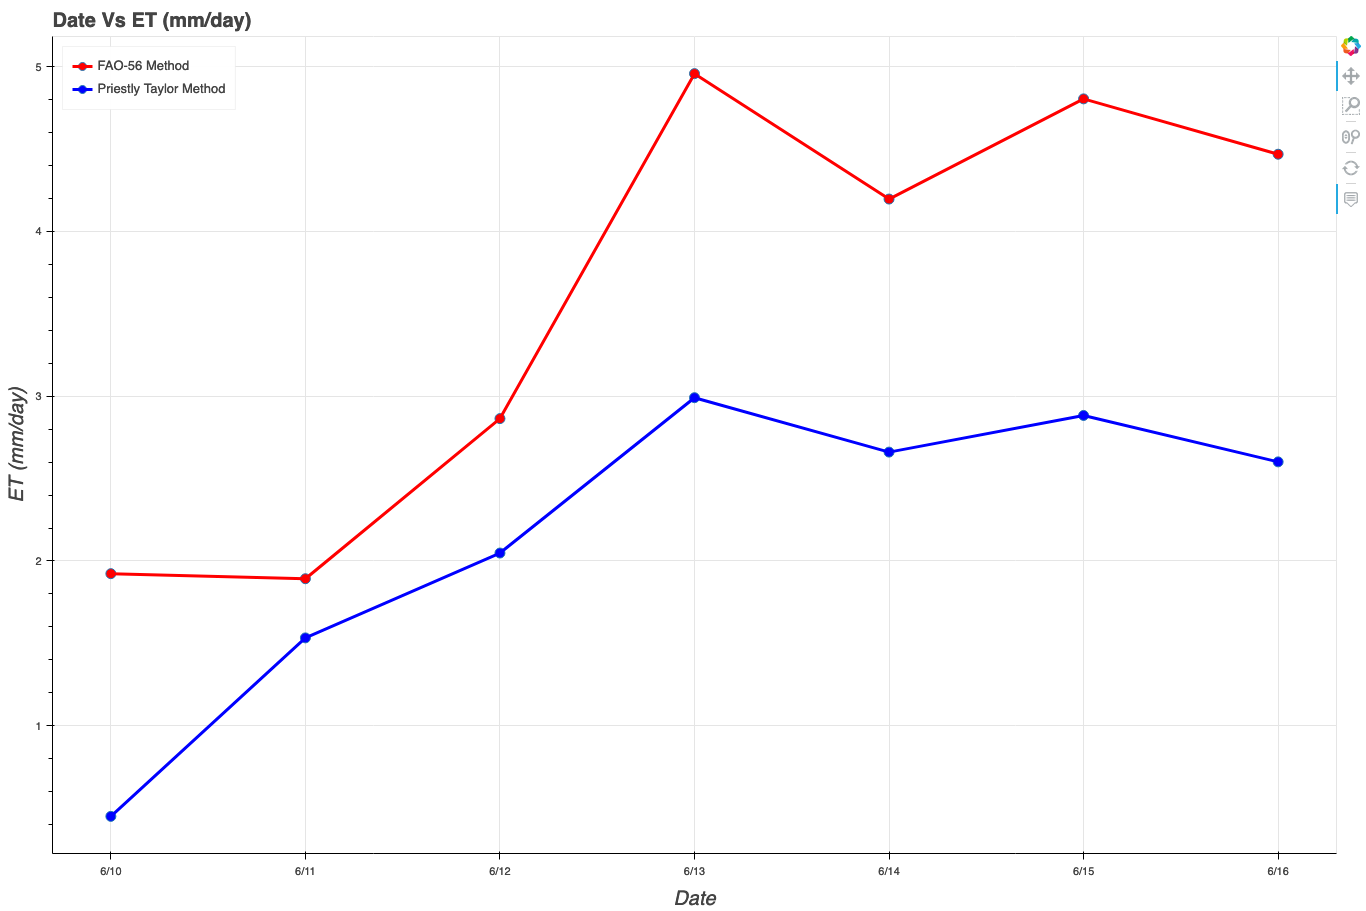

In [52]:
fig = initialize_fig(title = 'Date Vs ET (mm/day)',
                     x_axis_label = 'Date',
                     y_axis_label = 'ET (mm/day)',
                     x_axis_type = 'datetime',
                     tooltips = [
                         ('date', '$x{%F}'),
                         ('ET'  , '$y'),
                     ],
                     plot_height = 300,
                     formatters = { '$x' : 'datetime' },
                    )

fig.title.text_font_size = '15pt'
fig.xaxis.axis_label_text_font_size = '15pt'
fig.yaxis.axis_label_text_font_size = '15pt'

fig.circle(df.index, df.ET0_PM, fill_color='red', size=10, legend_label=f'FAO-56 Method')
fig.line(df.index, df.ET0_PM, line_width=3, line_color='red', legend_label=f'FAO-56 Method')
fig.circle(df.index, df.PET_PT, fill_color='blue', size=10, legend_label=f'Priestly Taylor Method')
fig.line(df.index, df.PET_PT, line_width=3, line_color='blue', legend_label=f'Priestly Taylor Method')

fig.legend.location = 'top_left'
fig.legend.click_policy='hide'
bp.show(fig)

export_png(fig, filename=f'{BASE_DIR}/problem_4.png', height=200, width=300)
Image(f'{BASE_DIR}/problem_4.png')

#### The Penman-Monteith Method of FAO has a higher value of ET than the Priestly Taylor Method. This is because of the fact that PM Method takes into consideration the atmospheric conductance and the canopy conductance. However, the mass tranfer term in the Priestly Taylor Method is neglected under the assumption that for a homogeneous well-watered surface would become saturated.

In [53]:
column_names = ['const', 'year', 'julian_day', 'HM', 'S', 'pressure', 'temp_2m', 'RH_2m', 'temp_10m', 'u_10m', 'ud_10m', 'Rin', 'rain', 'temp_0.5m', 'temp_1m']

In [54]:
df_14 = pd.read_csv(f'{BASE_DIR}/brm_20200614_sfc.csv', names=column_names)
df_14['datetime'] = '2020-06-14'

df_15 = pd.read_csv(f'{BASE_DIR}/brm_20200615_sfc.csv', names=column_names)
df_15['datetime'] = '2020-06-15'

df_16 = pd.read_csv(f'{BASE_DIR}/brm_20200616_sfc.csv', names=column_names)
df_16['datetime'] = '2020-06-16'

df_17 = pd.read_csv(f'{BASE_DIR}/brm_20200617_sfc.csv', names=column_names)
df_17['datetime'] = '2020-06-17'

df_18 = pd.read_csv(f'{BASE_DIR}/brm_20200618_sfc.csv', names=column_names)
df_18['datetime'] = '2020-06-18'

df_19 = pd.read_csv(f'{BASE_DIR}/brm_20200619_sfc.csv', names=column_names)
df_19['datetime'] = '2020-06-19'

df_20 = pd.read_csv(f'{BASE_DIR}/brm_20200620_sfc.csv', names=column_names)
df_20['datetime'] = '2020-06-20'

In [55]:
df_days = [df_14, df_15, df_16, df_17, df_18, df_19, df_20]

In [56]:
df1 = pd.DataFrame(columns=[
    'datetime', 'temp_mean_2m', 'Rin_avg', 'u_avg_2m', 'Δ_T', 'pressure_avg',
    'γ', 'DT', 'PT', 'TT', 'es', 'ea', 'dr', 'δ',  'φ_rad', 'ωs',
    'Ra', 'Rso', 'Rns', 'Rnl', 'Rn', 'Rng', 'ETrad', 'ETwind', 'ET0'
])

for df_day in df_days:
    # convert from fahrenheit to celsius
    df_day['temp_2m'] = (df_day['temp_2m'] - 32.) * (5. / 9.)
    # calculate mean temperature
    temp_mean_2m = (df_day['temp_2m'].max() + df_day['temp_2m'].min()) / 2

    # average daily radiation in MJ.m-2.day-1
    Rin_avg = df_day['Rin'].mean() * 0.0864
    
    # average wind speed at 2m
    u_avg_2m = (df_day['u_10m'] * 4.87 / math.log(672.58)).mean()
    
    # slope of saturation vapor pressure curve
    Δ_T = 4098 * (0.6108 * math.exp((17.27 * temp_mean_2m) / (temp_mean_2m + 237.3))) / (temp_mean_2m + 237.3)**2
    
    # average pressure
    pressure_avg = df_day['pressure'].mean()
    
    # Psychrometric constant
    γ = 0.000665 * pressure_avg

    # Delta Term (DT) (auxiliary calculation for Radiation Term)
    DT = Δ_T / (Δ_T + γ * (1 + 0.34 * u_avg_2m))

    # Psi Term (PT) (auxiliary calculation for Wind Term)
    PT = γ / (Δ_T + γ * (1 + 0.34 * u_avg_2m))
    
    # Temperature Term (TT) (auxiliary calculation for Wind Term)
    TT = (900 * u_avg_2m) / (temp_mean_2m + 273)

    # Mean saturation vapor pressure derived from air temperature(es)
    e_tmax = 0.6108 * math.exp( (17.27 * df_day['temp_2m'].max()) / (df_day['temp_2m'].max() + 237.7) )
    e_tmin = 0.6108 * math.exp( (17.27 * df_day['temp_2m'].min()) / (df_day['temp_2m'].min() + 237.7) )
    es = (e_tmax + e_tmin) / 2.
    
    # Actual vapor pressure (ea) derived from relative humidity
    ea = (df_day['RH_2m'].mean() / 100.) * ((e_tmin + e_tmax) / 2.)
    
    # The inverse relative distance Earth-Sun (dr) and solar declination (δ)
    # the julian_day value is same, so mean would give the same value
    dr = 1 + 0.033 * math.cos(2 * math.pi * df_day['julian_day'].mean() / 365. )
    δ = 0.409 * math.sin( (2 * math.pi * df_day['julian_day'].mean() / 365.) - 1.39 )
    
    # Conversion of latitude (φ) in degrees to radians
    φ_rad = math.pi * latitude / 180.
    
    # Sunset hour angle
    ωs = math.acos(-1 * math.tan(φ_rad) * math.tan(δ))
    
    # Extraterrestrial radiation (Ra)
    term_1 = (ωs * math.sin(φ_rad) * math.sin(δ)) + (math.cos(φ_rad) * math.cos(δ) * math.sin(ωs))
    Ra = 24. * 60. / math.pi * 0.0820 * dr * term_1
    
    # Clear sky solar radiation (Rso)
    Rso = (0.75 + 2 * 10**-5 * z) * Ra
    
    # Net solar or net shortwave radiation (Rns)
    Rns = (1. - 0.23) * Rin_avg
    
    # Net outgoing long wave solar radiation (Rnl)
    term_1 = ((df_day['temp_2m'].max() + 273.16)**4 + (df_day['temp_2m'].min() + 273.16)**4) / 2.
    term_2 = (0.34 - 0.14 * math.sqrt(ea))
    term_3 = 1.35 * (Rin_avg / Rso ) - 0.35
    Rnl = σ * term_1 * term_2 * term_3
    
    # Net radiation (Rn)
    Rn = Rns - Rnl
    # Net raduation in equivalent of evaporation (mm)
    Rng = 0.408 * Rn
    
    # FS1. Radiation term (ETrad)
    ETrad = DT * Rng
    
    # FS2. Wind term (ETwind)
    ETwind = PT * TT * (es - ea)
    
    # Final Reference Evapotranspiration Value (ETo)
    ET0 = ETwind + ETrad
    
    df_row = {
        'datetime'     : df_day.datetime.iloc[0],
        'temp_mean_2m' : temp_mean_2m,
        'Rin_avg'      : Rin_avg,
        'u_avg_2m'     : u_avg_2m,
        'Δ_T'          : Δ_T,
        'pressure_avg' : pressure_avg,
        'γ'            : γ,
        'DT'           : DT,
        'PT'           : PT,
        'TT'           : TT,
        'es'           : es,
        'ea'           : ea,
        'dr'           : dr,
        'δ'            : δ,
        'φ_rad'        : φ_rad,
        'ωs'           : ωs,
        'Ra'           : Ra,
        'Rso'          : Rso,
        'Rns'          : Rns,
        'Rnl'          : Rnl,
        'Rn'           : Rn,
        'Rng'          : Rng,
        'ETrad'        : ETrad,
        'ETwind'       : ETwind,
        'ET0'          : ET0,
        
    }
    df1 = df1.append(df_row, ignore_index=True)

df1.index = pd.to_datetime(df1['datetime'])
df1 = df1.drop(['datetime'], axis=1)

In [57]:
df1

,temp_mean_2m,Rin_avg,u_avg_2m,Δ_T,pressure_avg,γ,DT,PT,TT,es,...,ωs,Ra,Rso,Rns,Rnl,Rn,Rng,ETrad,ETwind,ET0
datetime,,,,,,,,,,,,,,,,,,,,,
2020-06-14,24.428975,23.989212,1.132383,0.183155,996.224439,0.662489,0.166397,0.601875,3.426516,3.289710,...,1.874018,41.592033,31.370375,18.471693,3.996675,14.475018,5.905807,0.982710,3.058170,4.040881
2020-06-15,22.343142,25.540423,1.506413,0.164112,997.542610,0.663366,0.140598,0.568320,4.590498,2.799549,...,1.874591,41.601611,31.377599,19.666126,4.479948,15.186178,6.195961,0.871140,2.978959,3.850099
2020-06-16,21.717239,18.654335,1.119263,0.158735,997.555055,0.663374,0.147721,0.617347,3.417978,2.692241,...,1.875060,41.608640,31.382900,14.363838,2.731093,11.632745,4.746160,0.701108,2.291512,2.992621
2020-06-17,21.799686,17.835425,1.190743,0.159434,995.475954,0.661992,0.146346,0.607647,3.635242,2.681610,...,1.875426,41.613122,31.386282,13.733278,2.475475,11.257803,4.593184,0.672194,2.260127,2.932321
2020-06-18,23.171550,20.773233,0.775550,0.171464,993.525169,0.660694,0.170378,0.656509,2.356724,3.004321,...,1.875687,41.615064,31.387746,15.995389,2.922396,13.072993,5.333781,0.908760,1.549243,2.458004
2020-06-19,25.073097,21.297904,0.833449,0.189399,993.924940,0.660960,0.182526,0.636973,2.516510,3.368961,...,1.875843,41.614466,31.387295,16.399386,2.983046,13.416340,5.473867,0.999122,1.980309,2.979432
2020-06-20,26.815189,24.035417,0.859619,0.207193,993.564264,0.660720,0.195276,0.622721,2.580447,3.740520,...,1.875895,41.611333,31.384932,18.507271,3.519361,14.987910,6.115067,1.194128,2.369680,3.563808


#### The data is for the summer time for 2012 and 2020. The ET is comparable. In Alabama, during summer, the radiation reaching the surface is high, and the precipitation also takes place. As a result, we have relatively balanced ET in the range of 1 mm upto 5 mm per day. The major factors affecting the ET besides the sunlight hours are the air temperature, relative humidity (i.e., vapor pressure deficit) and wind speed, which are relatively similar during the summer days. Noticable differences can be obtained if ET are compared between in the Fall or the Winter.